In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from mcmc import *
import pickle


## Wczytanie danych

In [2]:
with open("./data/corpus_wikipedia_2020-03-01_all_lines.txt") as f:
    lines = f.readlines(int(1e8))


In [3]:
full_text = " ".join(lines).lower().replace("!", ".")


In [4]:
len(full_text)


100888469

In [5]:
known_chars = "aąbcćdeęfghijklłmnńoóprsśtuvwxyzżź0123456789 ,."


In [6]:
full_text = remove_unknown_symbols(known_chars, full_text)


In [7]:
text_to_decode = (
    "na fundamentach starego urzędu gminy, rozpoczęto budowę nowego obiektu, mającego w przyszłości spełniać rolę gminnego ośrodka kultury gok."
    " uroczyście otwarty w dniu 23 maja 1989 r. gminny ośrodek kultury, zwany z racji widniejącego na frontonie rzeźby mitycznego pegaza,"
    " pod pegazem, okazał się wyśmienitym obiektem do pełnienia roli do jakiej został powołany."
).lower()


## Sprawdzenie wpływu długości tekstu wejściowego na stabilność dekodowania

In [39]:
text_lengths = [10**i for i in range(4, 8)] + [len(full_text)]


In [40]:
text_lengths


[10000, 100000, 1000000, 10000000, 98777608]

In [41]:
iters = int(1e4)
num_repeats = 50


In [42]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []
for text_length in text_lengths:
    count_dict = create_count_dict(full_text[:text_length], known_chars)
    perc_dict = create_perc_dict(count_dict, known_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
            crypt_text,
            perc_dict,
            crypt_keys,
            known_chars,
            iters,
            verbose=False,
            real_text=text_to_decode,
        )
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)


 88%|████████▊ | 8765/10000 [00:01<00:00, 4927.81it/s]

In [ ]:
with open("evaluations/text_length_tests/final_texts.pkl", "wb") as f:
    pickle.dump(final_texts, f)

np.save(
    "./evaluations/text_length_tests/hamming_losses.npy", hamming_losses_arrays
)
np.save("./evaluations/text_length_tests/scores.npy", runs_scores)


In [ ]:
threshold = 0.1
for hamming_losses_array in hamming_losses_arrays:
    print(
        "średnia:",
        np.mean(hamming_losses_array[:, -1]),
        f"\tponiżej {threshold}:",
        np.mean(hamming_losses_array[:, -1] < threshold),
    )


średnia: 0.9531481481481483 	poniżej 0.1: 0.0
średnia: 0.8072222222222223 	poniżej 0.1: 0.06666666666666667
średnia: 0.5661111111111112 	poniżej 0.1: 0.16666666666666666
średnia: 0.592037037037037 	poniżej 0.1: 0.1
średnia: 0.7434259259259259 	poniżej 0.1: 0.06666666666666667


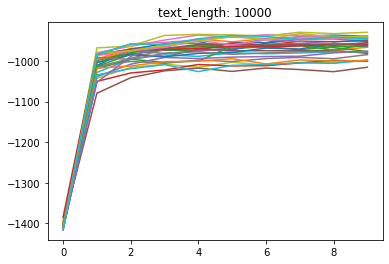

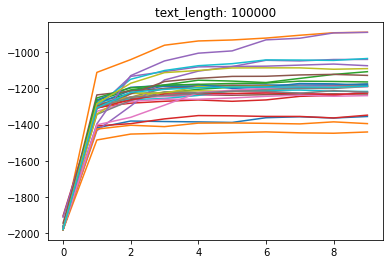

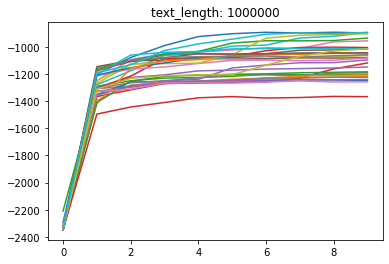

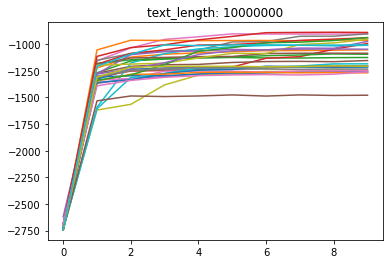

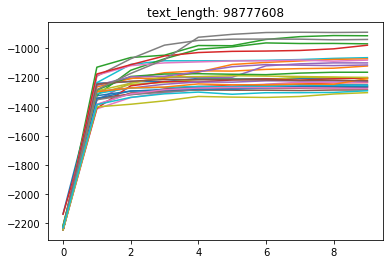

In [ ]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f"text_length: {text_lengths[run_num]}")
    plt.show()


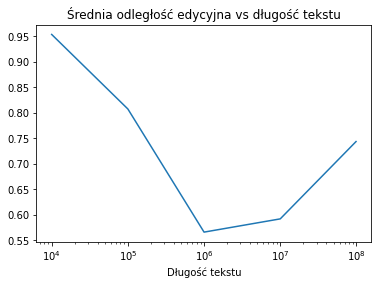

In [ ]:
ax = plt.plot(
    text_lengths,
    [
        np.mean(hamming_losses_array[:, -1])
        for hamming_losses_array in hamming_losses_arrays
    ],
)
plt.title("Średnia odległość edycyjna vs długość tekstu")
plt.xscale("log")
plt.xlabel("Długość tekstu")
plt.show()


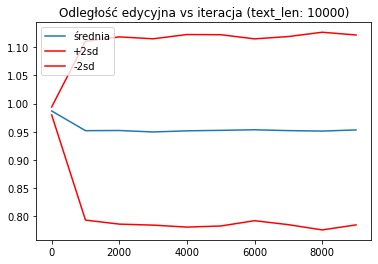

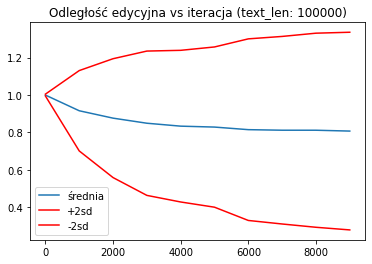

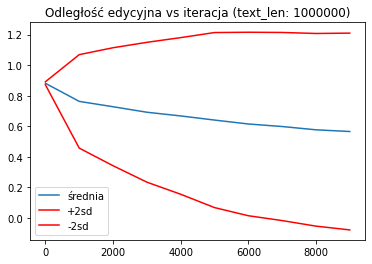

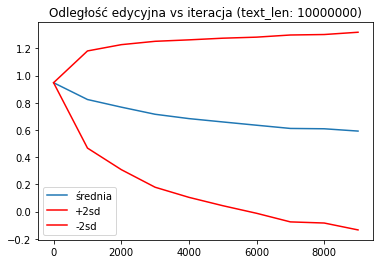

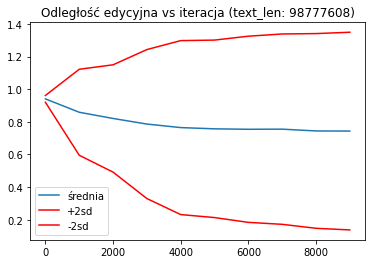

In [ ]:
xticks = [1000 * i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        + 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        - 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.title(f"Odległość edycyjna vs iteracja (text_len: {text_lengths[i]})")
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()


## Inicjacja słownika
Losujemy na początku k różnych słowników i wybieramy ten o najwyższej log wiarogodności

In [17]:
random.seed(123)
count_dict = create_count_dict(full_text, known_chars)
perc_dict = create_perc_dict(count_dict, known_chars)

crypt_keys = create_rand_crypt(known_chars)
crypt_dict = str_to_key(known_chars, crypt_keys)
crypt_text = apply_dict(text_to_decode, crypt_dict)


100%|██████████| 1966/1966 [00:00<00:00, 2038566.54it/s]


In [18]:
num_repeats = 50
num_tries_to_initiate_dict = 10**4
iters = int(1e4)


In [19]:
final_texts = []
run_scores = []
hamming_losses_array = []
for _ in range(num_repeats):
    current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
        crypt_text,
        perc_dict,
        crypt_keys,
        known_chars,
        iters,
        verbose=False,
        real_text=text_to_decode,
        num_tries_to_initiate_dict=num_tries_to_initiate_dict,
    )
    # print(hamming_losses[-1])
    hamming_losses_array.append(hamming_losses)
    final_texts.append(best_text[-1])
    run_scores.append(np.array(scores))
hamming_losses_array = np.array(hamming_losses_array)
run_scores = np.stack(run_scores)


In [20]:
with open("evaluations/initiation/final_texts.pkl", "wb") as f:
    pickle.dump(final_texts, f)

np.save("./evaluations/initiation/hamming_losses.npy", hamming_losses_array)
np.save("./evaluations/initiation/scores.npy", run_scores)


In [21]:
threshold = 0.1
print(
    "średnia:",
    np.mean(hamming_losses_array[:, -1]),
    f"\tponiżej {threshold}:",
    np.mean(hamming_losses_array[:, -1] < threshold),
)


średnia: 0.5139444444444444 	poniżej 0.1: 0.18


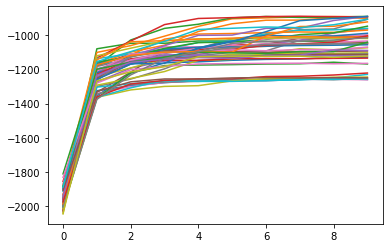

In [22]:
for i in range(run_scores.shape[0]):
    plt.plot(run_scores[i])
plt.show()


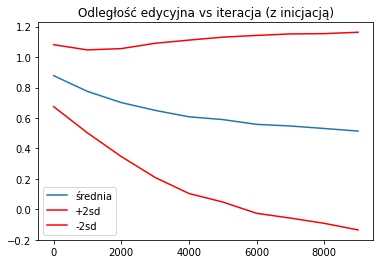

In [23]:
xticks = [1000 * i for i in range(len(hamming_losses))]
plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
plt.plot(
    xticks,
    np.mean(hamming_losses_array, axis=0)
    + 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
    c="red",
)
plt.plot(
    xticks,
    np.mean(hamming_losses_array, axis=0)
    - 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
    c="red",
)
plt.title(f"Odległość edycyjna vs iteracja (z inicjacją)")
plt.legend(("średnia", "+2sd", "-2sd"))
plt.show()


In [24]:
print(*final_texts, sep="\n\n")


tleńctzldwtalkżemal wórec ubzceódotnje ruśrkubarełczrgbetrgwórerłowiacjedlpękwóregeś unmusrykoemśwstolfe rhbeódottwórery rzileichac neórivec rkunykoweragl anegeztoce10edlple,585e veódottnery rzwieichac njeugltneue lkpoegoztowpękwóretleń rtartowe uwąłnedoankutwóreśwóluljeśrześwóluwdjerilulsemobegnydowtoanderłowiawdezreśwstowtole rhoezrepliowpeurmalseśrgrsltnv

na bundamentach starego urzędu gminy. rozpoczęto fudowę nowego ofiektu. mającego w przyszłości spełniaż rolę gminnego ośrodka kultury gok, uroczyście otwarty w dniu 19 maja 2858 r, gminny ośrodek kultury. zwany z racji widniejącego na brontonie rzećfy mitycznego pegaza. pod pegazem. okazał się wyśmienitym ofiektem do pełnienia roli do jakiej został powołany,

ra virpaderkach skanego intupi gdzry. notmoctuko bipowu rowego obzelki. dającego w mntystfoźcz smefrzań nołu gdzrrego oźnopla liłkiny gol, inoctyźcze okwanky w przi 20 daja 3515 n, gdzrry oźnopel liłkiny. twary t nacjz wzprzejącego ra vnorkorze nteżby dzkyctrego megata. mop m

## Zamiana więcej niż dwóch znaków w kodzie do odszyfrowania

In [25]:
start = 3
stop = 6
num_tries_to_initiate_dict = 10**4
iters = int(1e4)
num_repeats = 50

In [26]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []

for num_keys_to_shuffle in range(start, stop + 1):
    count_dict = create_count_dict(full_text, known_chars)
    perc_dict = create_perc_dict(count_dict, known_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
            crypt_text,
            perc_dict,
            crypt_keys,
            known_chars,
            iters,
            verbose=False,
            real_text=text_to_decode,
            num_keys_to_shuffle=2,
            num_tries_to_initiate_dict=10**4,
        )
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)


100%|██████████| 1966/1966 [00:00<00:00, 1911894.66it/s]


In [27]:
with open("evaluations/more_chars_swap/final_texts.pkl", "wb") as f:
    pickle.dump(final_texts, f)

np.save(
    "./evaluations/more_chars_swap/hamming_losses.npy", hamming_losses_arrays
)
np.save("./evaluations/more_chars_swap/scores.npy", runs_scores)


In [28]:
threshold = 0.1
for hamming_losses_array in hamming_losses_arrays:
    print(
        "średnia:",
        np.mean(hamming_losses_array[:, -1]),
        f"\tponiżej {threshold}:",
        np.mean(hamming_losses_array[:, -1] < threshold),
    )


średnia: 0.5301111111111111 	poniżej 0.1: 0.18
średnia: 0.4690555555555555 	poniżej 0.1: 0.14
średnia: 0.5893333333333334 	poniżej 0.1: 0.08
średnia: 0.5037222222222223 	poniżej 0.1: 0.22


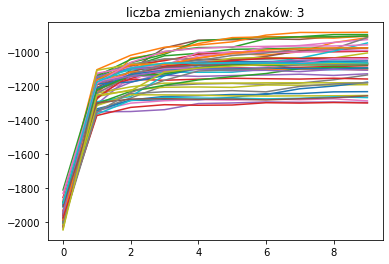

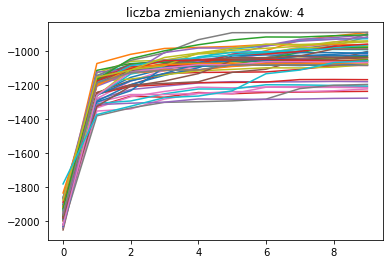

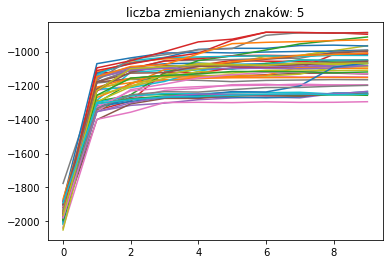

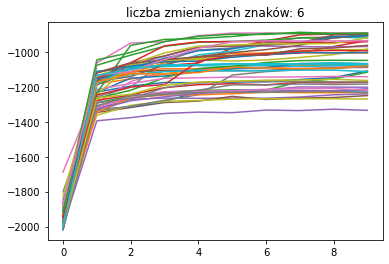

In [29]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f"liczba zmienianych znaków: {run_num+start}")
    plt.show()


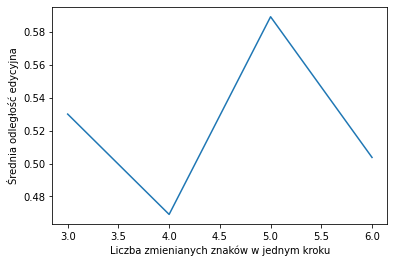

In [30]:
ax = plt.plot(
    range(start, stop + 1),
    [
        np.mean(hamming_losses_array[:, -1])
        for hamming_losses_array in hamming_losses_arrays
    ],
)
plt.ylabel("Średnia odległość edycyjna")
plt.xlabel("Liczba zmienianych znaków w jednym kroku")
plt.show()


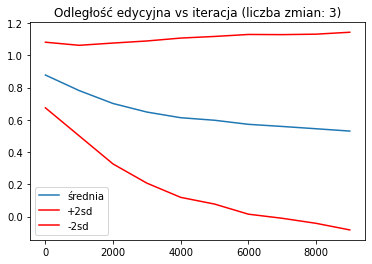

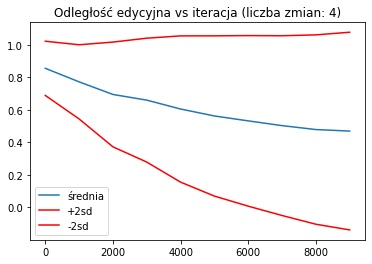

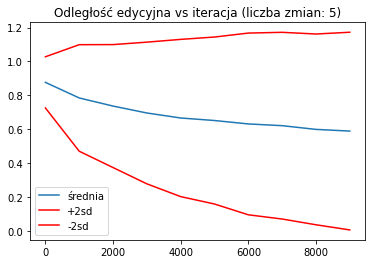

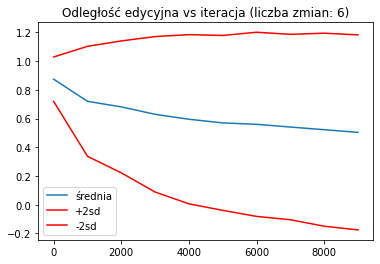

In [31]:
xticks = [1000 * i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        + 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        - 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.title(f"Odległość edycyjna vs iteracja (liczba zmian: {i+start})")
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()


## Więcej niż jeden znak do tyłu

In [32]:
iters = int(1e4)
num_repeats = 50
num_tries_to_initiate_dict = 10**4
start = 2
stop = 3

In [33]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []

for num_previous_chars in range(start, stop + 1):
    count_dict = create_count_dict(full_text, known_chars, num_previous_chars)
    perc_dict = create_perc_dict(count_dict, known_chars, num_previous_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, scores, best_text, hamming_losses = decrypt_MCMC(
            crypt_text,
            perc_dict,
            crypt_keys,
            known_chars,
            iters,
            verbose=False,
            real_text=text_to_decode,
            num_previous_chars=num_previous_chars,
            num_tries_to_initiate_dict = num_tries_to_initiate_dict
        )
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)


100%|██████████| 306086/306086 [00:00<00:00, 936493.74it/s]


In [34]:
with open("evaluations/more_prev_chars/final_texts.pkl", "wb") as f:
    pickle.dump(final_texts, f)

np.save(
    "./evaluations/more_prev_chars/hamming_losses.npy", hamming_losses_arrays
)
np.save("./evaluations/more_prev_chars/scores.npy", runs_scores)


In [8]:
runs_scores = np.load("./evaluations/more_prev_chars/scores.npy")
hamming_losses_arrays = np.load("./evaluations/more_prev_chars/hamming_losses.npy")
with open("evaluations/more_prev_chars/final_texts.pkl", "rb") as f:
    final_texts = pickle.load(f)

In [9]:
threshold = 0.1
for hamming_losses_array in hamming_losses_arrays:
    print(
        "średnia:",
        np.mean(hamming_losses_array[:, -1]),
        f"\tponiżej {threshold}:",
        np.mean(hamming_losses_array[:, -1] < threshold),
    )


średnia: 0.8482222222222222 	poniżej 0.1: 0.06
średnia: 0.8388333333333334 	poniżej 0.1: 0.0


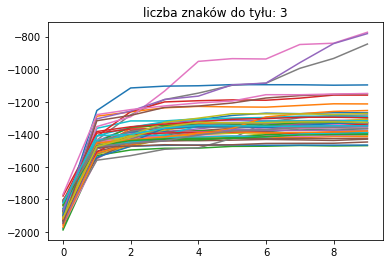

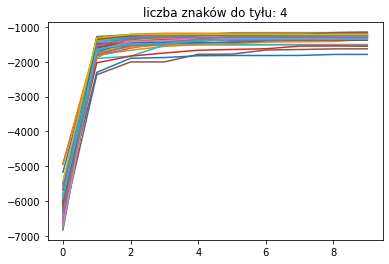

In [10]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f"liczba znaków do tyłu: {run_num+3}")
    plt.show()


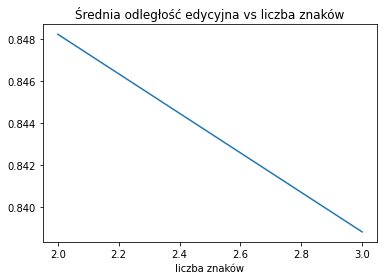

In [37]:
ax = plt.plot(
    range(start, stop + 1),
    [
        np.mean(hamming_losses_array[:, -1])
        for hamming_losses_array in hamming_losses_arrays
    ],
)
plt.title("Średnia odległość edycyjna vs liczba znaków")
plt.xlabel("liczba znaków")
plt.show()


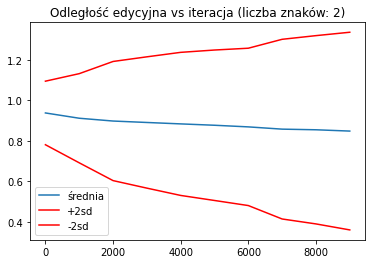

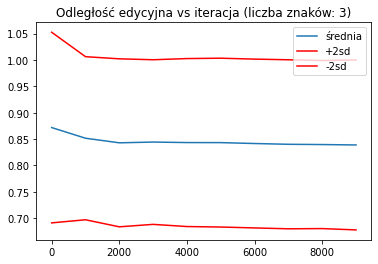

In [38]:
xticks = [1000 * i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        + 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.plot(
        xticks,
        np.mean(hamming_losses_array, axis=0)
        - 2 * np.sqrt(np.var(hamming_losses_array, axis=0)),
        c="red",
    )
    plt.title(f"Odległość edycyjna vs iteracja (liczba znaków: {i+start})")
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()
